In [1]:
import torch
from torch import nn
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from prettytable import PrettyTable

import albumentations
from albumentations import augmentations
import albumentations.pytorch

In [2]:
full_df = pd.read_csv('combo_all_FULL.csv')

In [3]:
root_folder = "Image_Manipulation_Dataset"
def load_images(row):

    image_patch, mask_patch, label, _, ela, root_dir = row

    #------------- Load image, Ela, Mask -------------------------
    image_path = os.path.join(root_folder, root_dir, image_patch)
    ela_path = os.path.join(root_folder, root_dir, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1])).astype('uint8')
    else:
        mask_path = os.path.join(root_folder, root_dir, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if('NIST' in root_dir):
        mask_image = 255 - mask_image

    image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
    mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
    ela_image = augmentations.geometric.functional.resize(ela_image, 256, 256, cv2.INTER_AREA)

    return image, ela_image, mask_image, label



def get_tensors(image, ela_image, mask_image):

    #---------------- Reshape & Normalize -----------------------
    image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
    mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
    ela_image = augmentations.geometric.functional.resize(ela_image, 256, 256, cv2.INTER_AREA)

    normalize = {
        "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
        "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
    }

    transforms_normalize = albumentations.Compose(
        [
            albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
            albumentations.pytorch.transforms.ToTensorV2()
        ],
        additional_targets={'ela':'image'}
    )

    data = transforms_normalize(image=image, mask=mask_image, ela=ela_image)
    image_tensor = data["image"].unsqueeze(0)
    mask_tensor = (data["mask"] / 255.0).unsqueeze(0).unsqueeze(0)
    ela_tensor = data["ela"].unsqueeze(0)
    
    return image_tensor, ela_tensor, mask_tensor
    

In [4]:
def patch_func(img, ela, mask, patch_size):
    d = img.shape
    patches = []
    coords = []
    for i in range(0, d[0], patch_size):
        for j in range(0, d[1], patch_size):
            x = i + patch_size
            y = j + patch_size
            if x > d[0] or y > d[1]:
                break
            temp_img = img[i: x, j: y]
            temp_ela = ela[i: x, j: y]
            temp_mask = mask[i: x, j: y]
            patches.append((temp_img, temp_mask, temp_ela))
            coords.append((i, j))
    return patches, coords

In [5]:
from segmentation.merged_net_old import SRM_Classifer_Old
from segmentation.timm_srm_unetpp import UnetPP

device = 'cuda'

encoder = SRM_Classifer_Old(encoder_checkpoint='best_weights/CASIA_FULL_ELA.h5', freeze_encoder=False)
model_256 = UnetPP(encoder, num_classes=1, layer='end')
model_256 = nn.DataParallel(model_256)
model_256.load_state_dict(torch.load('best_weights/CASIA_FULL_UNETPP_END-END.h5'))

# model_256 = SRM_Classifer()
# model_256 = nn.DataParallel(model_256).to(device)
# model_256.load_state_dict(torch.load('weights/classifier.6.bias_[18|03_13|54|23].h5'))

# model_128 = SRM_Classifer()
# model_128 = nn.DataParallel(model_128).to(device)
# model_128.load_state_dict(torch.load('best_weights/COMBO_ALL_128ChangedClass_[09|03_21|11|14].h5'))

# model_64 = SRM_Classifer()
# model_64 = nn.DataParallel(model_64).to(device)
# model_64.load_state_dict(torch.load('best_weights/(Resume 22-35-18) COMBO_ALL_64ChangedClass_[11|03_18|46|12].h5'))

--------- Loaded Checkpoint: best_weights/CASIA_FULL_ELA.h5 ----------
<All keys matched successfully>


<All keys matched successfully>

In [6]:
def get_feat_preds(row):
    model_256.eval()
    # model_128.eval()
    # model_64.eval()
    
    with torch.no_grad():
        image_256, ela_image_256, mask_image_256, label = load_images(row)
        features = []
        predictions = []
        masks = []

        #--------- 256x256 ----------        
        image_tensor_256, ela_tensor_256, mask_tensor_256 = get_tensors(image_256, ela_image_256, mask_image_256)
        # outputs.clear()
        pred_256 = model_256(image_tensor_256.to(device), ela_tensor_256.to(device))
        # features.append(inter_256.cpu().detach())
        predictions.append(torch.sigmoid(pred_256.cpu().detach()))
        masks.append(mask_tensor_256)

        # #--------- 128x128 ----------
        # patches_128, _ = patch_func(image_256, ela_image_256, mask_image_256, 128)
        # for patch in patches_128:
        #     image_128, mask_image_128, ela_image_128 = patch
        #     image_tensor_128, ela_tensor_128, mask_tensor_128 = get_tensors(image_128, ela_image_128, mask_image_128)
            
        #     # outputs.clear()
        #     pred_128, inter_128, _ = model_128(image_tensor_128.to(device), ela_tensor_128.to(device))
        #     features.append(inter_128.cpu().detach())
        #     predictions.append(torch.sigmoid(pred_128.cpu().detach()))
        
        # #--------- 64x64 ----------
        # patches_64, _ = patch_func(image_256, ela_image_256, mask_image_256, 64)
        # for patch in patches_64:
        #     image_64, mask_image_64, ela_image_64 = patch
        #     image_tensor_64, ela_tensor_64, mask_tensor_64 = get_tensors(image_64, ela_image_64, mask_image_64)
            
        #     # outputs.clear()
        #     pred_64, inter_64, _ = model_64(image_tensor_64.to(device), ela_tensor_64.to(device))
        #     features.append(inter_64.cpu().detach())
        #     predictions.append(torch.sigmoid(pred_64.cpu().detach()))

    return predictions, masks

In [7]:
"CMFD, NIST, COVERAGE, CASIA, IMD"

def get_individual_test_df(dataframe, val):
    test_df = dataframe[dataframe['root_dir'].str.contains(val)]
    test_df = dataframe[dataframe['label'] == 1]
    test_df = test_df[test_df["fold"].isin([1])]

    print(
        "{}: real:{}, fakes:{}".format(
            val, len(test_df[test_df["label"] == 0]), len(test_df[test_df["label"] == 1])
        )
    )
    return test_df.values
    
casia_test = get_individual_test_df(full_df, "CASIA")
# imd_test = get_individual_test_df(full_df, "IMD")
# coverage_test = get_individual_test_df(full_df, "COVERAGE")
# nist_test = get_individual_test_df(full_df, "NIST")

CASIA: real:0, fakes:1059


In [9]:
coverage_full = full_df[full_df['root_dir'].str.contains('COVERAGE')]
nist_full = full_df[full_df['root_dir'].str.contains('NIST')]

In [20]:
nist_full.label.value_counts()

0    874
1    388
Name: label, dtype: int64

## SVM Classifier

In [8]:
def feat_pool(feat: torch.tensor, operation: str):
    """
    Fuses the image's patches feature representation
    :param feat: The network object
    :param operation: Either max or mean for the pooling operation
    :returns: The final 256-D feature representation of the entire image
    """
    if operation == "max":
        return feat.max(axis=0)
    elif operation == "mean":
        return feat.mean(axis=0)
    else:
        raise Exception("The operation can be either mean or max")

In [8]:
testX = []
testY = []
predY = []

for row in tqdm(casia_test):

    predictions, masks = get_feat_preds(row)
    
    # features = torch.vstack(features)
    # condensed_feature = feat_pool(features, "mean").numpy().reshape(1, -1)

    # testX.append(condensed_feature)
    testY.append(masks[0].squeeze())  
    predY.append(predictions[0].squeeze())

100%|██████████| 1059/1059 [01:32<00:00, 11.46it/s]


In [17]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(np.array(testY), np.array(predY) >= 0.5))

Test Accuracy: 0.6850393700787402


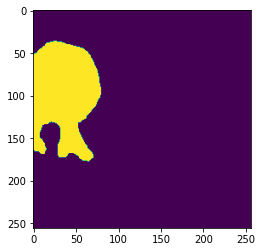

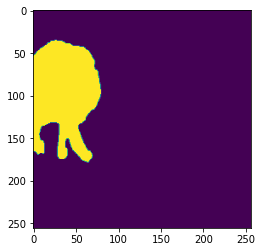

In [33]:
plt.figure()
plt.imshow(predY[2] >= 0.5)
plt.show()
plt.figure()
plt.imshow(testY[2])
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

auc = 0
for gt, pr in zip(testY, predY):
    auc += roc_auc_score(gt.numpy().ravel() >= 0.5, pr.numpy().ravel() >= 0.5)
auc / len(testY)

0.5781546208439655

In [90]:
XTest = np.vstack(testX)
YTest = np.array(testY)
print(XTest.shape, YTest.shape)

(220, 256) (220,)


In [91]:
import pickle
from sklearn.metrics import accuracy_score

svm_model = pickle.load(open('svm.sav', 'rb'))
# result = svm_model.score(XTest, YTest)
y_pred = svm_model.predict(XTest)
roc_auc_score(YTest, y_pred)
# print("Test Accuracy:", accuracy_score(YTest, y_pred))

0.5272727272727273

In [75]:
result

0.7606973058637084